In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Read the csv file and plot the data
To understand what's in the data we first read in the dataset and visualize a few images and their steering angles

In [2]:
rmwhtspc = lambda x: x.strip()
def read_csv_data(root, add_root_to_path = False):
    driving_df = pd.read_csv(os.path.join(root, "driving_log.csv"), header = 0, 
                                          names = ["center", "left", "right", "steering", "throttle", "brake", "speed"])
    if add_root_to_path:
        driving_df["center"] = root + "/" + driving_df["center"].astype("str").map(rmwhtspc)
        driving_df["left"] = root + "/" + driving_df["left"].astype("str").map(rmwhtspc)
        driving_df["right"] = root + "/" +  driving_df["right"].astype("str").map(rmwhtspc)
 
    return driving_df

datadir = "../data"
df1 = read_csv_data(datadir, True)
df1.tail()

,center,left,right,steering,throttle,brake,speed
8031,../data/IMG/center_2016_12_01_13_46_38_745.jpg,../data/IMG/left_2016_12_01_13_46_38_745.jpg,../data/IMG/right_2016_12_01_13_46_38_745.jpg,0.0,0.0,0.0,1.402436
8032,../data/IMG/center_2016_12_01_13_46_38_802.jpg,../data/IMG/left_2016_12_01_13_46_38_802.jpg,../data/IMG/right_2016_12_01_13_46_38_802.jpg,0.0,0.0,0.0,1.393976
8033,../data/IMG/center_2016_12_01_13_46_38_846.jpg,../data/IMG/left_2016_12_01_13_46_38_846.jpg,../data/IMG/right_2016_12_01_13_46_38_846.jpg,0.0,0.0,0.0,1.388364
8034,../data/IMG/center_2016_12_01_13_46_38_922.jpg,../data/IMG/left_2016_12_01_13_46_38_922.jpg,../data/IMG/right_2016_12_01_13_46_38_922.jpg,0.0,0.0,0.0,1.377208
8035,../data/IMG/center_2016_12_01_13_46_38_947.jpg,../data/IMG/left_2016_12_01_13_46_38_947.jpg,../data/IMG/right_2016_12_01_13_46_38_947.jpg,0.0,0.0,0.0,1.374433


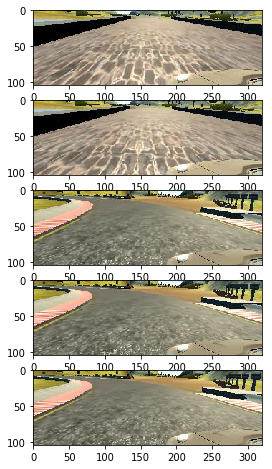

In [3]:
#Visualize some data
n = np.random.randint(0, df1.shape[0], 5)
w, h = 6, 8
fig = plt.figure(figsize = (w,h))

def process_image(img):
    img_out = img[55:,:]
    #print(img_out.shape)
    return img_out

for i, idx in enumerate(n):
    fig.add_subplot(5, 1, i+1)
    img = process_image(plt.imread( df1.iloc[i]["left"]))
    plt.imshow(img)

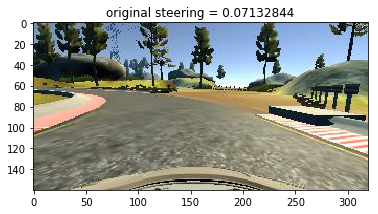

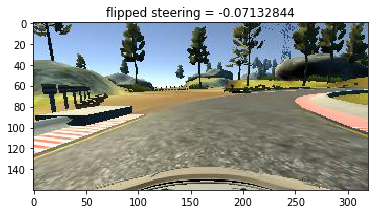

In [4]:
#Unit test some image transformations for data augmentation

def flip_img(img, steering):
    out_img = np.fliplr(img)
    out_steer = - steering
    return out_img, out_steer
    
#Plot flipped image for debugging
im = plt.imread(df1.iloc[10]["center"])
steer = df1.iloc[1030]["steering"]

flipped_im, flipped_steer = flip_img(im, steer)
plt.figure()
plt.imshow(im)
plt.title("original steering = " + str(steer))

plt.figure()
plt.imshow(flipped_im)
plt.title("flipped steering = " + str(flipped_steer))

Data type for image 31 =  float32
Mean for Image 23 =  161.934


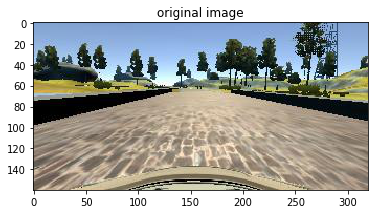

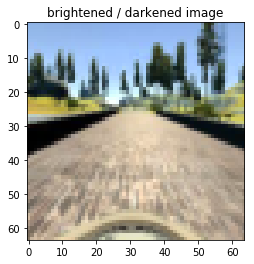

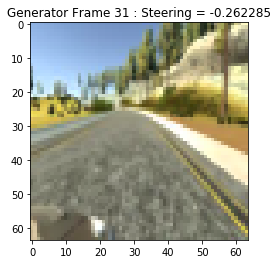

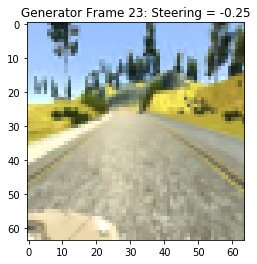

In [5]:
import sklearn.utils
from skimage import color
from scipy.misc import imresize

#data augmentation technique
def image_brighten_darken(img, scale=0.3):
    img = imresize(img, (64, 64))
    #Use HSV color space to increase or descrease the image brightness
    hsv = color.rgb2hsv(img)
    v = hsv[:, :, 2] * (1 + np.random.uniform(-scale, scale))
    v[ v > 1] = 1
    v[ v < 0] = 0
    hsv[:, :, 2] = v
    #We multiply back with 255 so that the model's normalization layer 
    #will apply at run time
    rgb = color.hsv2rgb(hsv).astype(np.float32) * 255
    return rgb

#debug
im = plt.imread( df1.iloc[0]["center"])
plt.figure()
plt.imshow(im)
plt.title("original image")
plt.figure()
im2 = image_brighten_darken(im, scale = 0.3)
plt.imshow(im2.astype(np.uint8))
plt.title("brightened / darkened image")

#Keras generator: This generator will yeild x,y the batch size 
def genbatchdata(data, batch_size = 32, correction = 0.25):
    num_samples = data.shape[0]
    while 1:
        idxes = np.random.permutation(num_samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = idxes[offset:offset+batch_size]

            images = np.zeros((batch_size, 64, 64, 3), dtype = np.float32)
            targets = np.zeros((batch_size,), dtype = np.float32)
            
            for i, batch_sample in enumerate(batch_samples):
                row = data.iloc[batch_sample]
                center_name = row["center"]
                left_name = row["left"]
                right_name = row["right"]
                
                steering = row["steering"].astype(np.float32) 
                
                #With lower probability pick center images
                choice = np.random.choice(3, p = [0.1, 0.45, 0.45])
                if choice == 0:
                    img = image_brighten_darken(plt.imread(center_name))
                elif choice == 1:
                    img = image_brighten_darken(plt.imread(left_name))
                    steering = steering + correction
                elif choice == 2:
                    img = image_brighten_darken(plt.imread(right_name))
                    steering = steering - correction
                
                #Toss a coin and flip the image 
                if np.random.choice(2) == 1:
                    img, steering = flip_img(img, steering)
              
                images[i] = img
                targets[i] = steering

            yield images, targets

def print_batch(debug):
    if debug:
        g = genbatchdata(df1)
        x, y = next(g)
        plt.figure()
        plt.imshow(x[31].astype(np.uint8))
        plt.title("Generator Frame 31 : Steering = " + str(y[31]))
        print("Data type for image 31 = ", x[31].dtype)
        plt.figure()
        plt.imshow(x[23].astype(np.uint8))
        plt.title("Generator Frame 23: Steering = " + str(y[23]))
        #make sure data is scaled correctly
        print("Mean for Image 23 = ", x[23].mean())

debug = True
print_batch(debug)

### Create the Neural Network model

In [9]:
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, Cropping2D, \
                         BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard

from keras.applications.inception_v3 import InceptionV3

#Not used eventually, but tried transfer learning from InceptionV3 model
def inceptiontlmodel():
    #input 
    input_tensor = Input(shape=(64, 64, 3))
    #normalize data
    normalized_tensor = Lambda(lambda x: (x / 127.5) - 1. )(input_tensor)
    #crop image
    cropped_tensor = Cropping2D(cropping=((55,20), (0,0)))(normalized_tensor)
    #base model with cropped image tensor as input
    base_model = InceptionV3(input_tensor=cropped_tensor, weights='imagenet', include_top=False)
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(512, activation = "relu", name = "fc1")(x)
    x = Dropout(0.5)(x)
    x = Dense(300, activation = "relu", name = "fc2")(x)
    # and a regression layer
    predictions = Dense(1, name = "steering")(x)
    # this is the model we will train
    model = Model(inputs=input_tensor, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer = "adam", loss="mse", metrics = ["accuracy"])
    return model

#This model replicates the NVIDIA model
#https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
def nvidiamodel():
    model = Sequential()
    #Cropping doesn't seem to be necessary when the image is resized
    #model.add(Cropping2D(cropping=((55,20), (0,0)), input_shape = (64, 64, 3) ) )
    model.add(Lambda(lambda x:  (x / 127.5) - 1., input_shape = (64, 64, 3) ))
    model.add(Conv2D(24, 5, strides =(2,2) , activation = "relu"))
    model.add(Conv2D(36, 5, strides = 2, activation = "relu"))
    model.add(Conv2D(48, 3, strides = 2, activation = "relu"))
    model.add(Conv2D(64, 3, strides = 2, activation = "relu"))
    #I chose to remove the final conv layer because the input shape is 64 64 3 and the 
    #feature maps are already 2x2x64 at this stage
    #model.add(Conv2D(64, 3, strides = 2, activation = "relu"))
    model.add(Flatten())
    model.add(Dense(1164, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = "relu"))
    model.add(Dense(50, activation = "relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, name = "predictions"))
    model.compile(optimizer = "adam", loss = "mse")
    return model

#Not used eventually
def simplemodel():
    model = Sequential()
    model.add(Cropping2D(cropping=((55,20), (0,0)), input_shape = (160, 320, 3) )) 
    model.add(Lambda(lambda x:  (x / 127.5) - 1.) )    
    model.add(Conv2D(32, 5, strides = 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 5, strides = 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation  = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = "relu"))
    model.add(Dense(1))
    model.compile(optimizer = "adam", loss = "mse")
    return model
    

In [10]:
shouldLoadExistingModel = False
if shouldLoadExistingModel and os.path.exists("model.h5"):
    print("Load existing model")
    model = load_model("model.h5")
else:
    model = nvidiamodel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 48)          15600     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 64)          27712     
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1164)              299148    
__________

In [11]:
df1 = read_csv_data("../data", True)
df2 = read_csv_data("../drivingdata2")
df3 = read_csv_data("../drivingdatachallenge1")
df = pd.concat( [df1, df2, df3])
df.tail()


#drop 70% of the rows that have a steering between -0.5 and 0.5
mask1 = df.steering > -0.5
mask2 = df.steering < 0.5
mask = mask1 & mask2
df = df.drop(mask.sample(frac = 0.7).index)
#Create some validation data by using 20% of the dataset
traindf=df.sample(frac=0.9,random_state=200)
testdf=df.drop(traindf.index)
testdf.head()

,center,left,right,steering,throttle,brake,speed
3598,../data/IMG/center_2016_12_01_13_38_42_894.jpg,../data/IMG/left_2016_12_01_13_38_42_894.jpg,../data/IMG/right_2016_12_01_13_38_42_894.jpg,1.000000,0.495593,0.0,20.157950
3602,../data/IMG/center_2016_12_01_13_38_43_300.jpg,../data/IMG/left_2016_12_01_13_38_43_300.jpg,../data/IMG/right_2016_12_01_13_38_43_300.jpg,0.000000,0.000000,0.0,19.107410
3612,../data/IMG/center_2016_12_01_13_38_44_318.jpg,../data/IMG/left_2016_12_01_13_38_44_318.jpg,../data/IMG/right_2016_12_01_13_38_44_318.jpg,0.000000,0.000000,0.0,17.573810
3649,../data/IMG/center_2016_12_01_13_38_48_073.jpg,../data/IMG/left_2016_12_01_13_38_48_073.jpg,../data/IMG/right_2016_12_01_13_38_48_073.jpg,0.176582,0.000000,0.0,11.075260
3666,../data/IMG/center_2016_12_01_13_38_49_802.jpg,../data/IMG/left_2016_12_01_13_38_49_802.jpg,../data/IMG/right_2016_12_01_13_38_49_802.jpg,0.138308,0.000000,0.0,9.317094


### Train the Network

In [12]:

batch_size = 64
num_train_batches = traindf.shape[0] // batch_size
num_test_batches = testdf.shape[0] // batch_size
if num_test_batches == 0:
    num_test_batches = 1
print(num_test_batches)
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, period = 5)
tbcbk = TensorBoard(log_dir='./logs', histogram_freq=5, batch_size=batch_size, write_graph=True)
model.fit_generator(genbatchdata(traindf, batch_size), num_train_batches, epochs = 60, 
                    callbacks = [checkpointer, tbcbk],
                    validation_data = genbatchdata(testdf, batch_size),
                    validation_steps = num_test_batches)
model.save('nvidiamodel.h5')


2
INFO:tensorflow:Summary name conv2d_5/kernel:0 is illegal; using conv2d_5/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_5/bias:0 is illegal; using conv2d_5/bias_0 instead.
INFO:tensorflow:Summary name conv2d_6/kernel:0 is illegal; using conv2d_6/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_6/bias:0 is illegal; using conv2d_6/bias_0 instead.
INFO:tensorflow:Summary name conv2d_7/kernel:0 is illegal; using conv2d_7/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_7/bias:0 is illegal; using conv2d_7/bias_0 instead.
INFO:tensorflow:Summary name conv2d_8/kernel:0 is illegal; using conv2d_8/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_8/bias:0 is illegal; using conv2d_8/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorf